## Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Dataset

We are using the data for the volume of widget sales for the XYZ Widget Company. The dataset contains 500 days of sales volume data starting on January 1, 2019. We want to predict the sales for the next 50 days.

In [2]:
df = pd.read_csv('datasets/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


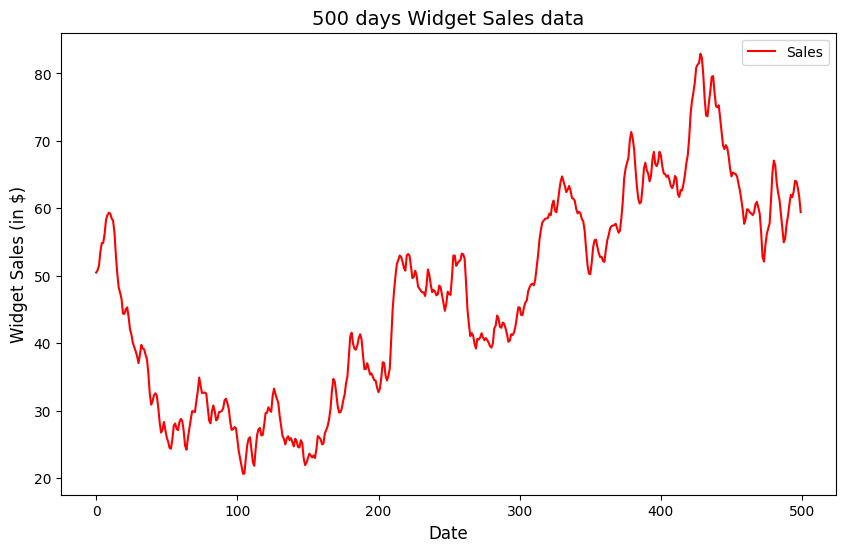

In [3]:
# Plot the stock prices
plt.figure(figsize=(10,6))
plt.plot(df['widget_sales'], label='Sales', color='r')

# Adding labels and title
plt.title('500 days Widget Sales data', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Widget Sales (in $)', fontsize=12)
plt.legend()

# Display the plot
plt.show()

## A Moving Average Process

A moving average model is denoted as MA(q), where q is the order. The model expresses the present value as a linear combination of the mean of the series µ, the present error term ϵt, and past error terms ϵt–q.

` yt = µ + ϵt + θ1ϵt–1 + θ2ϵt–2 +⋅⋅⋅+ θqϵt–q`

In [4]:
# Check for stationarity
adf_result = adfuller(df)
print(f'ADF Score: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Score: -1.5121662069358992
p-value: 0.5274845352272632


In [28]:
# Applying transformation to make the series stationary
first_diff = np.diff(df['widget_sales'], n=1)  # First order differencing

# Check for stationarity
adf_result_diff = adfuller(first_diff)
print(f'ADF Score: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')

ADF Score: -10.576657780341957
p-value: 7.076922818587346e-19


Text(0, 0.5, 'Values')

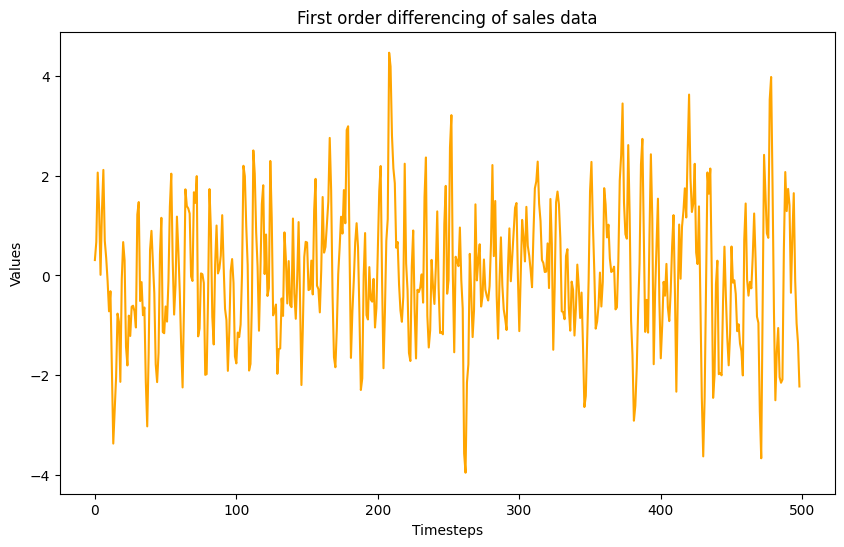

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(first_diff, color ='orange')
plt.title('First order differencing of sales data')
plt.xlabel('Timesteps')
plt.ylabel('Values')

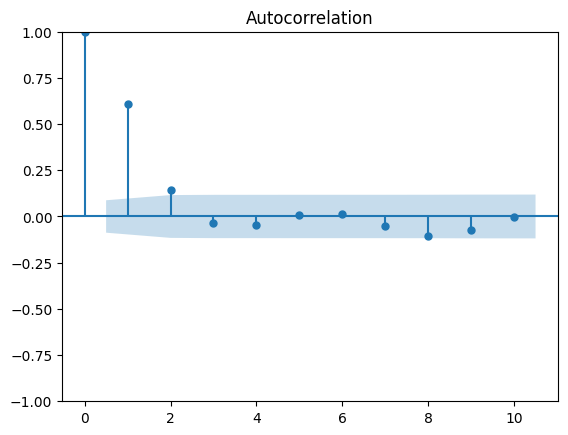

In [30]:
# Checking autocorrelation of the stationary series
plot_acf(first_diff, lags=10)
plt.show()

Hence, we have obtained a stationary moving average process of order 2.

## Forecasting a moving average process

A moving average model assumes stationarity, so we'll train our model on the first order difference of our series and then *inverse-transform* the forecast back to the original scale.

In [31]:
first_diff = pd.DataFrame({'widget_sales_diff': first_diff})

# Obtaining the train and test set
train = first_diff[:int(0.9*len(first_diff))]
test = first_diff[int(0.9*len(first_diff)):]

In [32]:
print(len(first_diff))
print(len(train))
print(len(test))

499
449
50


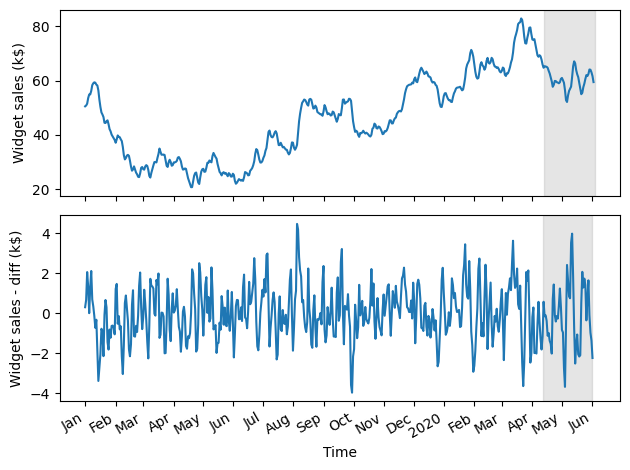

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True) 

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(first_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [34]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str):
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            cos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(cos_pred)

        return pred_MA

In [36]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(first_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')

pred_last_value = rolling_forecast(first_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')

pred_MA = rolling_forecast(first_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


(430.0, 500.0)

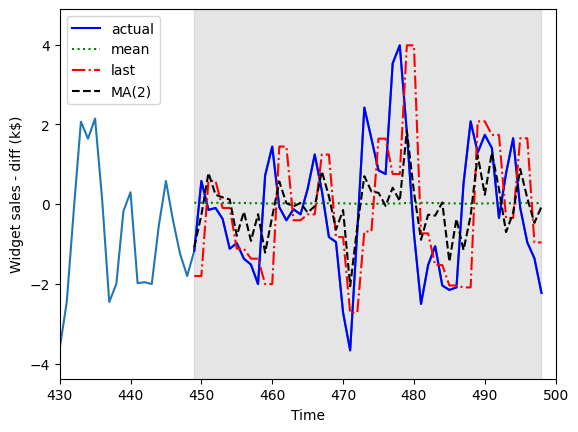

In [42]:
plt.plot(first_df['widget_sales'])
plt.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
plt.plot(pred_df['pred_mean'], 'g:', label='mean')
plt.plot(pred_df['pred_last_value'], 'r-.', label='last')
plt.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

plt.legend(loc=2)

plt.xlabel('Time')
plt.ylabel('Widget sales - diff (k$)')

plt.axvspan(449, 498, color='#808080', alpha=0.2)
plt.xlim(430, 500)


In [44]:
# Measure the performance of different models

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497548293


In [46]:
# Inverse-transform the predictions
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_10544\1827857185.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
C:\Users\Divya Tiwari\AppData\

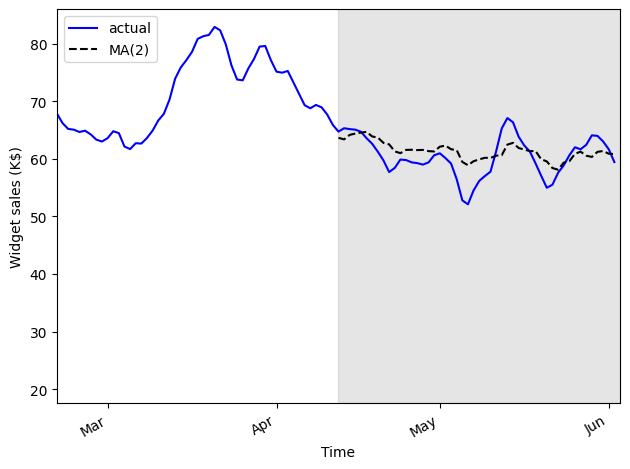

In [47]:
fig, ax = plt.subplots()
ax.plot(df['widget_sales'], 'b-', label='actual')    
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(400, 500)
plt.xticks([409, 439, 468, 498], ['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [48]:
mse_MA_undiff = mean_squared_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mse_MA_undiff)

8.024638120148687


In [51]:
mea_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mea_MA_undiff)

2.3244709244095954
